# Scratchpad

This is just for me to experiment with stuff. Don't pay attention.

## OpenEMS Tutorials

I want to run through the tutorials a bit before I dive head first into the deep end.

### Waveguide

From: https://openems.readthedocs.io/en/latest/python/openEMS/Tutorials/Rect_Waveguide.html

In [1]:
import os, tempfile
from pylab import *

from CSXCAD  import ContinuousStructure
from openEMS import openEMS
from openEMS.physical_constants import *

original_path = os.getcwd()
sim_path = os.path.join(os.getcwd(), 'horn_antenna_sim/Rect_WG')
if not os.path.exists(sim_path):
    os.mkdir(sim_path)

post_proc_only = False
unit = 1e-6 #drawing unit in micrometers

# waveguide dimensions
# WR42
a = 10700   #waveguide width
b = 4300    #waveguide height
length = 50000

# frequency range of interest
f_start = 20e9
f_0     = 24e9
f_stop  = 26e9
lambda0 = C0/f_0/unit

#waveguide TE-mode definition
TE_mode = 'TE10'

#targeted mesh resolution
mesh_res = lambda0/30

# Setup FDTD parameter & excitation function
FDTD = openEMS(NrTS=1e4)
FDTD.SetGaussExcite(0.5*(f_start+f_stop),0.5*(f_stop-f_start))

# boundary conditions
FDTD.SetBoundaryCond([0, 0, 0, 0, 3, 3])

# Setup geometry & mesh
CSX = ContinuousStructure()
FDTD.SetCSX(CSX)
mesh = CSX.GetGrid()
mesh.SetDeltaUnit(unit)

mesh.AddLine('x', [0, a])
mesh.AddLine('y', [0, b])
mesh.AddLine('z', [0, length])

# Apply the waveguide port
ports = []
start=[0, 0, 10*mesh_res]
stop =[a, b, 15*mesh_res]
mesh.AddLine('z', [start[2], stop[2]])
ports.append(FDTD.AddRectWaveGuidePort( 0, start, stop, 'z', a*unit, b*unit, TE_mode, 1))

start=[0, 0, length-10*mesh_res]
stop =[a, b, length-15*mesh_res]
mesh.AddLine('z', [start[2], stop[2]])
ports.append(FDTD.AddRectWaveGuidePort( 1, start, stop, 'z', a*unit, b*unit, TE_mode))

mesh.SmoothMeshLines('all', mesh_res, ratio=1.4)

# Define dump box…
Et = CSX.AddDump('Et', file_type=0, sub_sampling=[2,2,2])
start = [0, 0, 0]
stop  = [a, b, length]
Et.AddBox(start, stop)

# Save the mesh to file
CSX_file = os.path.join(sim_path, 'debug_mesh_rect_wg.xml')
CSX.Write2XML(CSX_file)
print(f"Mesh saved to: {CSX_file}")


Mesh saved to: /home/kaitlyn/Workspaces/hydrogen-line-horn-antenna/horn_antenna_sim/Rect_WG/debug_mesh_rect_wg.xml


In [2]:
# Run the simulation
if 0:  # debugging only
    CSX_file = os.path.join(sim_path, 'rect_wg.xml')
    if not os.path.exists(sim_path):
        os.mkdir(sim_path)
    CSX.Write2XML(CSX_file)
    from CSXCAD import AppCSXCAD_BIN
    os.system(AppCSXCAD_BIN + ' "{}"'.format(CSX_file))

if not post_proc_only:
    FDTD.Run(sim_path, cleanup=True)

os.chdir(original_path)

 ---------------------------------------------------------------------- 
 | openEMS 64bit -- version v0.0.36-133-gb0b8351
 | (C) 2010-2025 Thorsten Liebig <thorsten.liebig@gmx.de>  GPL license
 ---------------------------------------------------------------------- 
	Used external libraries:
		CSXCAD -- Version: v0.6.3-93-g28ac614
		hdf5   -- Version: 1.10.10
		          compiled against: HDF5 library version: 1.10.10
		tinyxml -- compiled against: 2.6.2
		fparser
		boost  -- compiled against: 1_83
		vtk -- Version: 9.1.0
		       compiled against: 9.1.0

Create FDTD operator (compressed SSE + multi-threading)
FDTD simulation size: 27x12x132 --> 42768 FDTD cells 
FDTD timestep is: 5.18459e-13 s; Nyquist rate: 37 timesteps @2.60648e+10 Hz
Excitation signal length is: 1842 timesteps (9.55001e-10s)
Max. number of timesteps: 10000 ( --> 5.42888 * Excitation signal length)
Create FDTD engine (compressed SSE + multi-threading)
Running FDTD engine... this may take a while... grab a cup of coff

RunFDTD: Warning: Max. number of timesteps was reached before the end-criteria of -60dB was reached... 
	You may want to choose a higher number of max. timesteps... 


Time for 10000 iterations with 42768 cells : 2.03438 sec
Speed: 210.226 MCells/s 


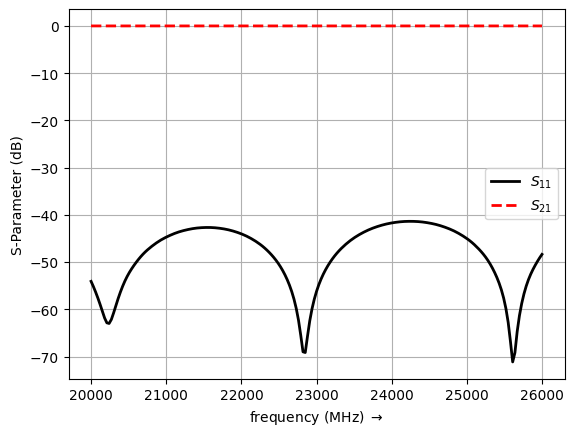

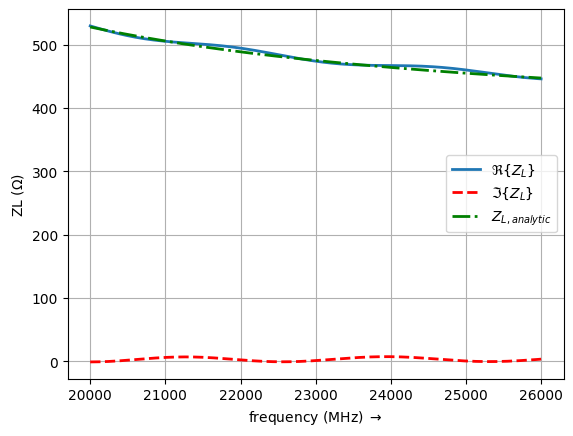

In [3]:
# Postprocessing & plotting
freq = linspace(f_start,f_stop,201)
for port in ports:
    port.CalcPort(sim_path, freq)

s11 = ports[0].uf_ref / ports[0].uf_inc
s21 = ports[1].uf_ref / ports[0].uf_inc
ZL  = ports[0].uf_tot / ports[0].if_tot
ZL_a = ports[0].ZL # analytic waveguide impedance

# Plot S-parameters
figure()
plot(freq*1e-6,20*log10(abs(s11)),'k-',linewidth=2, label=r'$S_{11}$')
grid()
plot(freq*1e-6,20*log10(abs(s21)),'r--',linewidth=2, label=r'$S_{21}$')
legend();
ylabel('S-Parameter (dB)')
xlabel(r'frequency (MHz) $\rightarrow$')

# Compare analytic and numerical wave-impedance
figure()
plot(freq*1e-6,real(ZL), linewidth=2, label=r'$\Re\{Z_L\}$')
grid()
plot(freq*1e-6,imag(ZL),'r--', linewidth=2, label=r'$\Im\{Z_L\}$')
plot(freq*1e-6,ZL_a,'g-.',linewidth=2, label=r'$Z_{L, analytic}$')
ylabel(r'ZL $(\Omega)$')
xlabel(r'frequency (MHz) $\rightarrow$')
legend()

show()